# Convolutional Neural Networks: Step by Step

Welcome to Course 4's first assignment! In this assignment, you will implement convolutional (CONV) and pooling (POOL) layers in numpy, including both forward propagation and (optionally) backward propagation. 

By the end of this notebook, you'll be able to: 

* Explain the convolution operation
* Apply two different types of pooling operation
* Identify the components used in a convolutional neural network (padding, stride, filter, ...) and their purpose
* Build a convolutional neural network 

**Notation**:
- Superscript $[l]$ denotes an object of the $l^{th}$ layer. 
    - Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.


- Superscript $(i)$ denotes an object from the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example input.
    
    
- Subscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$, assuming this is a fully connected (FC) layer.
    
    
- $n_H$, $n_W$ and $n_C$ denote respectively the height, width and number of channels of a given layer. If you want to reference a specific layer $l$, you can also write $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ and $n_{C_{prev}}$ denote respectively the height, width and number of channels of the previous layer. If referencing a specific layer $l$, this could also be denoted $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$. 

You should be familiar with `numpy` and/or have completed the previous courses of the specialization. Let's get started!

## Table of Content

- [1 - Packages](#1)
- [2 - Outline of the Assignment](#2)
- [3 - Convolutional Neural Networks](#3)
    - [3.1 - Zero-Padding](#3-1)
        - [Exercise 1 - zero_pad](#ex-1)
    - [3.2 - Single Step of Convolution](#3-2)
        - [Exercise 2 - conv_single_step](#ex-2)
    - [3.3 - Convolutional Neural Networks - Forward Pass](#3-3)
        - [Exercise 3 - conv_forward](#ex-3)
- [4 - Pooling Layer](#4)
    - [4.1 - Forward Pooling](#4-1)
        - [Exercise 4 - pool_forward](#ex-4)
- [5 - Backpropagation in Convolutional Neural Networks (OPTIONAL / UNGRADED)](#5)
    - [5.1 - Convolutional Layer Backward Pass](#5-1)
        - [5.1.1 - Computing dA](#5-1-1)
        - [5.1.2 - Computing dW](#5-1-2)
        - [5.1.3 - Computing db](#5-1-3)
            - [Exercise 5 - conv_backward](#ex-5)
    - [5.2 Pooling Layer - Backward Pass](#5-2)
        - [5.2.1 Max Pooling - Backward Pass](#5-2-1)
            - [Exercise 6 - create_mask_from_window](#ex-6)
        - [5.2.2 - Average Pooling - Backward Pass](#5-2-2)
            - [Exercise 7 - distribute_value](#ex-7)
        - [5.2.3 Putting it Together: Pooling Backward](#5-2-3)
            - [Exercise 8 - pool_backward](#ex-8)

<a name='1'></a>
## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- np.random.seed(1) is used to keep all the random function calls consistent. This helps to grade your work.

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
import sys

In [17]:
sys.path.append("/content/gdrive/MyDrive/Colab Notebooks/coursera programming practice/class4/C4W1/CNN step by step")

In [18]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
## 2 - Outline of the Assignment

You will be implementing the building blocks of a convolutional neural network! Each function you will implement will have detailed instructions to walk you through the steps:

- Convolution functions, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward (optional)
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward (optional)
    
This notebook will ask you to implement these functions from scratch in `numpy`. In the next notebook, you will use the TensorFlow equivalents of these functions to build the following model:

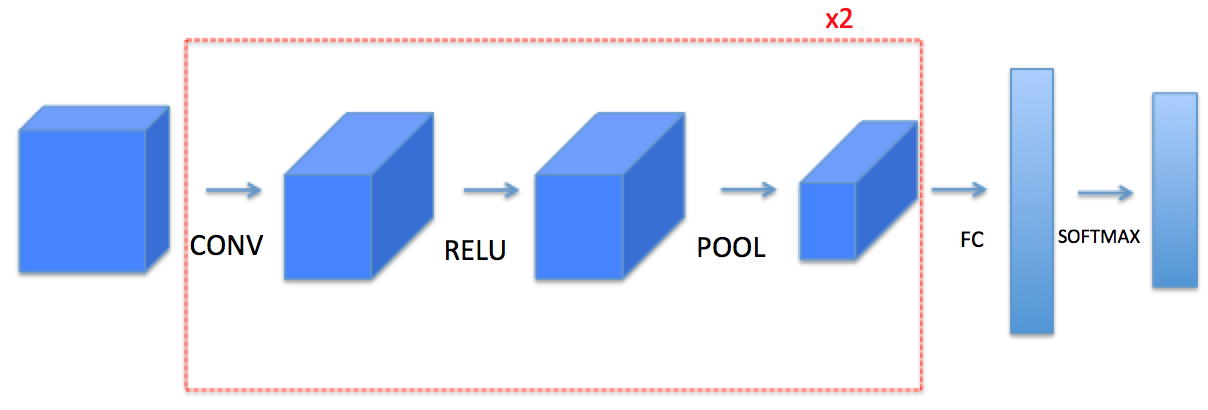

**Note**: For every forward function, there is a corresponding backward equivalent. Hence, at every step of your forward module you will store some parameters in a cache. These parameters are used to compute gradients during backpropagation. 

<a name='3'></a>
## 3 - Convolutional Neural Networks

Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. A convolution layer transforms an input volume into an output volume of different size, as shown below. 

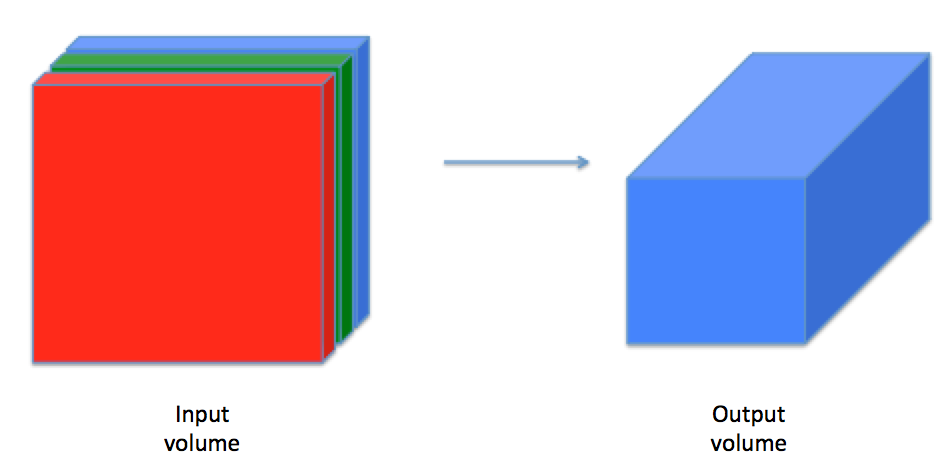

In this part, you will build every step of the convolution layer. You will first implement two helper functions: one for zero padding and the other for computing the convolution function itself. 

### 3.1 - Zero-Padding

Zero-padding adds zeros around the border of an image:


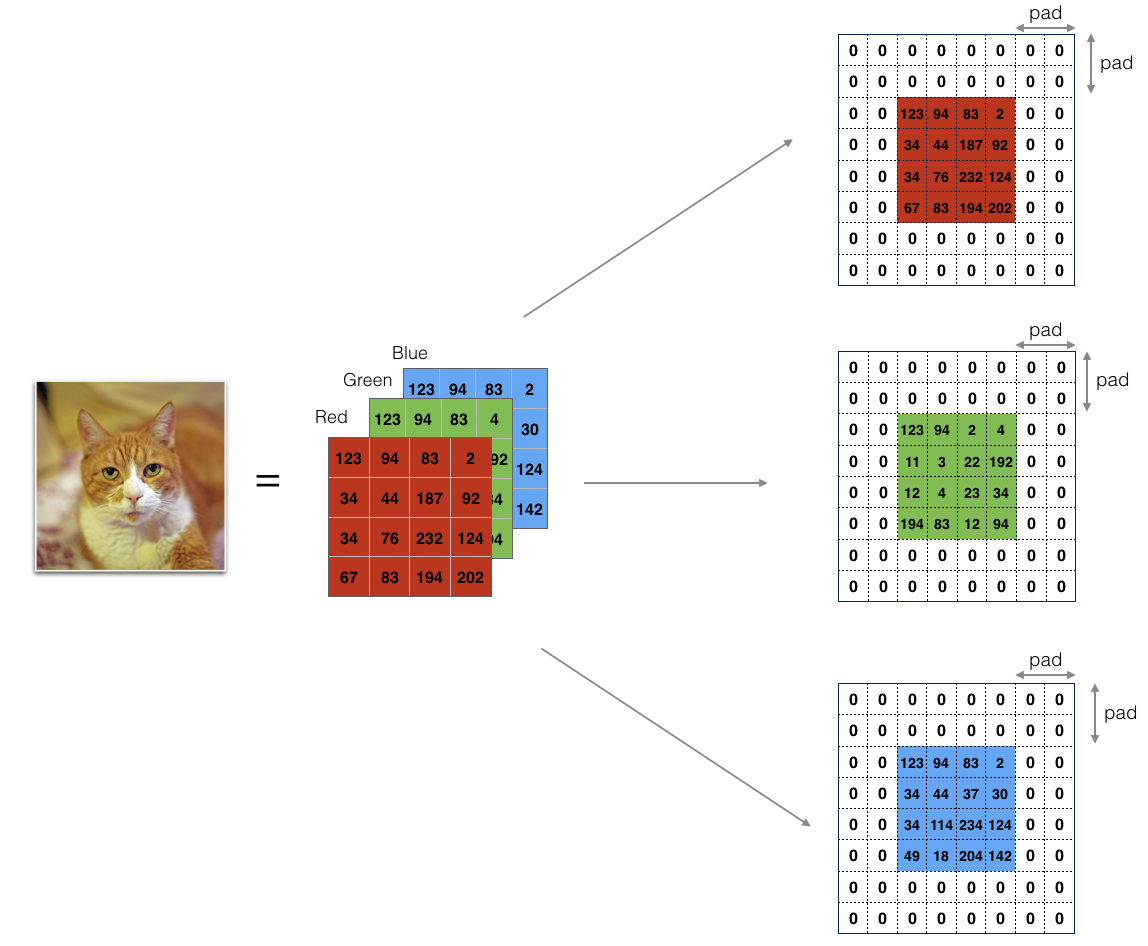

<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>Zero-Padding</b><br> Image (3 channels, RGB) with a padding of 2. </center></caption>

The main benefits of padding are:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels at the edges of an image.

<a name='ex-1'></a>
### Exercise 1 - zero_pad
Implement the following function, which pads all the images of a batch of examples X with zeros. [Use np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). Note if you want to pad the array "a" of shape $(5,5,5,5,5)$ with `pad = 1` for the 2nd dimension, `pad = 3` for the 4th dimension and `pad = 0` for the rest, you would do:
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))
```

In [20]:
a = np.array([[ 1.,  1.,  1.,  1.,  1.],
               [ 1.,  1.,  1.,  1.,  1.],
               [ 1.,  1.,  1.,  1.,  1.]])
print(a.shape)
b = np.pad(a, [(0, 1), (0, 1)], mode='constant')

(3, 5)


In [21]:
b.shape

(4, 6)

In [22]:
b

array([[1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
a = np.zeros((5,5,5,5,5))

In [ ]:
a.shape

(5, 5, 5, 5, 5)

In [ ]:
a

In [ ]:
b = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))

In [ ]:
b.shape

(5, 7, 5, 11, 5)

In [ ]:
b

In [25]:
a = [1, 2, 3, 4, 5]

In [26]:
b = np.pad(a, (2, 3), 'constant', constant_values=(4, 6))

In [27]:
b

array([4, 4, 1, 2, 3, 4, 5, 6, 6, 6])

Zero-padding adds zeros around the border of an image:

In [28]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
    
    #(≈ 1 line)
    # X_pad = None
    # YOUR CODE STARTS HERE
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)))    
    # YOUR CODE ENDS HERE
    
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
 All tests passed.


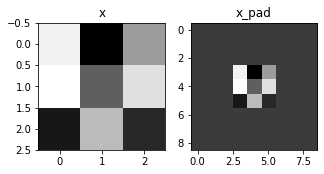

In [29]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1, 1])
print ("x_pad[1,1] =\n", x_pad[1, 1])

assert type(x_pad) == np.ndarray, "Output must be a np array"
assert x_pad.shape == (4, 9, 9, 2), f"Wrong shape: {x_pad.shape} != (4, 9, 9, 2)"
print(x_pad[0, 0:2,:, 0])
assert np.allclose(x_pad[0, 0:2,:, 0], [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 1e-15), "Rows are not padded with zeros"
assert np.allclose(x_pad[0, :, 7:9, 1].transpose(), [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 1e-15), "Columns are not padded with zeros"
assert np.allclose(x_pad[:, 3:6, 3:6, :], x, 1e-15), "Internal values are different"

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])
zero_pad_test(zero_pad)

<a name='3-2'></a>
### 3.2 - Single Step of Convolution 

In this part, implement a single step of convolution, in which you apply the filter to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

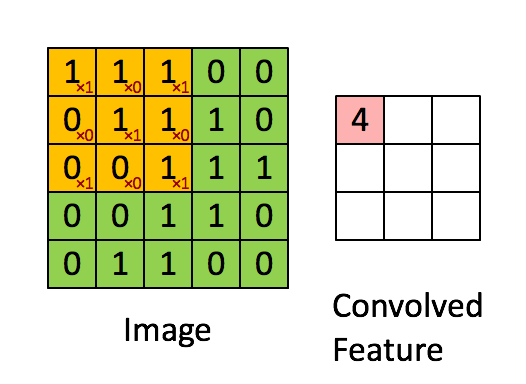

<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : <b>Convolution operation</b><br> with a filter of 3x3 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>

In a computer vision application, each value in the matrix on the left corresponds to a single pixel value. You convolve a 3x3 filter with the image by multiplying its values element-wise with the original matrix, then summing them up and adding a bias. In this first step of the exercise, you will implement a single step of convolution, corresponding to applying a filter to just one of the positions to get a single real-valued output. 

Later in this notebook, you'll apply this function to multiple positions of the input to implement the full convolutional operation. 

<a name='ex-2'></a>
### Exercise 2 - conv_single_step
Implement `conv_single_step()`. 
    
[Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html).

**Note**: The variable b will be passed in as a numpy array.  If you add a scalar (a float or integer) to a numpy array, the result is a numpy array.  In the special case of a numpy array containing a single value, you can cast it as a float to convert it to a scalar.

In [30]:
# GRADED FUNCTION: conv_single_step

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """
    
    #(≈ 3 lines of code)
    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    # s = None
    # Sum over all entries of the volume s.
    # Z = None
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    # Z = None
    # YOUR CODE STARTS HERE  
    # print("a_slice_prev.shape=", a_slice_prev.shape) (3, 3, 4)
    s = np.multiply(a_slice_prev,W)
    Z = np.sum(s)

    b = np.squeeze(b)
    Z = Z + b
    # YOUR CODE ENDS HERE

    return Z

In [31]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)
conv_single_step_test(conv_single_step)

assert (type(Z) == np.float64 or type(Z) == np.float32), "You must cast the output to float"
assert np.isclose(Z, -6.999089450680221), "Wrong value"

Z = -6.999089450680221
 All tests passed.


<a name='3-3'></a>
### 3.3 - Convolutional Neural Networks - Forward Pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume: 

<center>
<font color="red"><b>동영상 참조 : conv_kiank.mp4</b></font>
</center>



<a name='ex-3'></a>
### Exercise 3 -  conv_forward
Implement the function below to convolve the filters `W` on an input activation `A_prev`.  
This function takes the following inputs:
* `A_prev`, the activations output by the previous layer (for a batch of m inputs); 
* Weights are denoted by `W`.  The filter window size is `f` by `f`.
* The bias vector is `b`, where each filter has its own (single) bias. 

You also have access to the hyperparameters dictionary, which contains the stride and the padding. 

**Hint**: 
1. To select a 2x2 slice at the upper left corner of a matrix "a_prev" (shape (5,5,3)), you would do:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
Notice how this gives a 3D slice that has height 2, width 2, and depth 3.  <font color="red">Depth is the number of channels.</font>  
This will be useful when you will define `a_slice_prev` below, using the `start/end` indexes you will define.

2. To define a_slice you will need to first define its corners `vert_start`, `vert_end`, `horiz_start` and `horiz_end`. This figure may be helpful for you to find out how each of the corners can be defined using h, w, f and s in the code below.

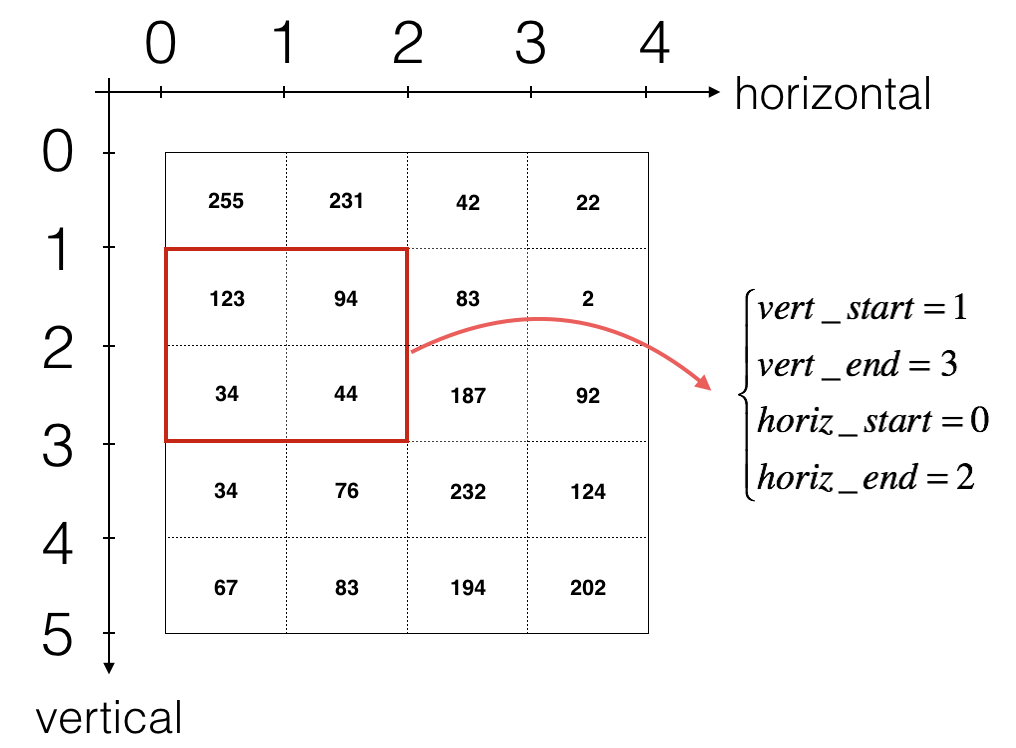
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Definition of a slice using vertical and horizontal start/end (with a 2x2 filter)</b> <br> This figure shows only a single channel.  </center></caption>


**Reminder**:
    
The formulas relating the output shape of the convolution to the input shape are:
    
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$
    



For this exercise, don't worry about vectorization! Just implement everything with for-loops.

#### Additional Hints (if you're stuck):


* Use array slicing (e.g.`varname[0:1,:,3:5]`) for the following variables:  
  `a_prev_pad` ,`W`, `b`  
  - Copy the starter code of the function and run it outside of the defined function, in separate cells.  
  - Check that the subset of each array is the size and dimension that you're expecting.  
* To decide how to get the `vert_start`, `vert_end`, `horiz_start`, `horiz_end`, remember that these are indices of the previous layer.  
  - Draw an example of a previous padded layer (8 x 8, for instance), and the current (output layer) (2 x 2, for instance).  
  - The output layer's indices are denoted by `h` and `w`.  
* Make sure that `a_slice_prev` has a height, width and depth.
* Remember that `a_prev_pad` is a subset of `A_prev_pad`.  
  - Think about which one should be used within the for loops.

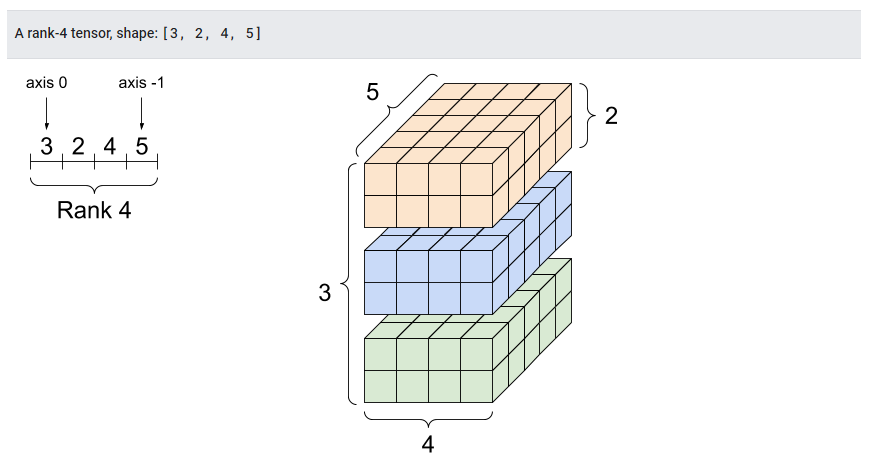

In [34]:
# GRADED FUNCTION: conv_forward

def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    print("W.shape=", W.shape)
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape  # W.shape= (3, 3, 4, 8)
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. (≈2 lines)
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)  #
    print("A_prev_pad.shape=", A_prev_pad.shape) # (2, 7, 9, 4)

    onlyone = 0
    
    for i in range(m):                            # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i] # (7,9,4)                # Select ith training example's padded activation
        for h in range(n_H):  #7         # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = stride * h 
            vert_end = vert_start  + f
            
            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" (≈2 lines)
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    # print("a_slice_prev.shape=", a_slice_prev.shape) # (3, 3, 4)
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    weights = W[:, :, :, c] ################################################# (3, 3, 4, 8)
                    if onlyone == 0:
                      print("weights=", weights)
                      print("weights.shape=", weights.shape)
                      onlyone += 1
                    # print("weights.shape=", weights.shape) # (3, 3, 4)
                    biases  = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
# print("W=", W)
# print("*"*60)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[0,2,1] =\n", Z[0, 2, 1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

conv_forward_test(conv_forward)


In [36]:
W

array([[[[-0.78191168, -0.43750898,  0.09542509,  0.92145007,
           0.0607502 ,  0.21112476,  0.01652757,  0.17718772],
         [-1.11647002,  0.0809271 , -0.18657899, -0.05682448,
           0.49233656, -0.68067814, -0.08450803, -0.29736188],
         [ 0.417302  ,  0.78477065, -0.95542526,  0.58591043,
           2.06578332, -1.47115693, -0.8301719 , -0.8805776 ],
         [-0.27909772,  1.62284909,  0.01335268, -0.6946936 ,
           0.6218035 , -0.59980453,  1.12341216,  0.30526704]],

        [[ 1.3887794 , -0.66134424,  3.03085711,  0.82458463,
           0.65458015, -0.05118845, -0.72559712, -0.86776868],
         [-0.13597733, -0.79726979,  0.28267571, -0.82609743,
           0.6210827 ,  0.9561217 , -0.70584051,  1.19268607],
         [-0.23794194,  1.15528789,  0.43816635,  1.12232832,
          -0.9970198 , -0.10679399,  1.45142926, -0.61803685],
         [-2.03720123, -1.94258918, -2.50644065, -2.11416392,
          -0.41163916,  1.27852808, -0.44222928,  0.32352735]

In [37]:
W[:, :, :, 0]

array([[[-0.78191168, -1.11647002,  0.417302  , -0.27909772],
        [ 1.3887794 , -0.13597733, -0.23794194, -2.03720123],
        [-0.10999149, -0.19505734, -0.55749472,  0.58464661]],

       [[ 2.13782807,  0.61798553, -0.47537288, -1.30653407],
        [ 0.45161595, -0.77785883,  2.0546241 ,  0.84086156],
        [ 0.45128402, -0.38483225, -0.82246719, -0.0693287 ]],

       [[-0.19899818,  0.5154138 ,  1.04008915,  0.52887975],
        [-0.25898285,  0.16986926,  1.44287693,  0.63658341],
        [ 0.68400133, -2.22711263,  1.01120706,  0.85328219]]])

Finally, a CONV layer should also contain an activation, in which case you would add the following line of code:

```python
# Convolve the window to get back one output neuron
Z[i, h, w, c] = ...
# Apply activation
A[i, h, w, c] = activation(Z[i, h, w, c])
```

You don't need to do it here, however. 


<a name='4'></a>
## 4 - Pooling Layer 

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

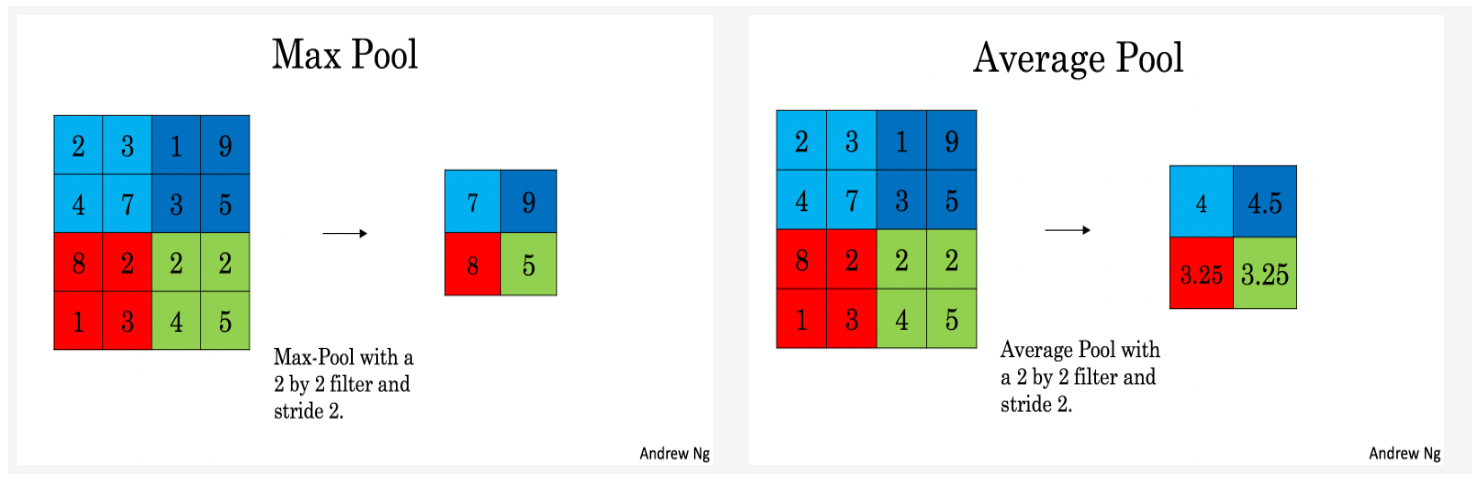

These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. This specifies the height and width of the $f \times f$ window you would compute a *max* or *average* over. 

<a name='4-1'></a>
### 4.1 - Forward Pooling
Now, you are going to implement MAX-POOL and AVG-POOL, in the same function. 

<a name='ex-4'></a>
### Exercise 4 - pool_forward

Implement the forward pass of the pooling layer. Follow the hints in the comments below.

**Reminder**:
As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_C = n_{C_{prev}}$$




In [ ]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    ### START CODE HERE ###
    for i in range(m):                         # loop over the training examples
        a_prev_slice = A_prev[i]
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = stride * h 
            vert_end = vert_start + f
            
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_slice_prev = a_prev_slice[vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_slice_prev)
                    else:
                        print(mode+ "-type pooling layer NOT Defined")    
    # YOUR CODE ENDS HERE
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [ ]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])

pool_forward_test(pool_forward)

mode = max
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]

mode = average
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]
 All tests passed.


**Expected output**

```
mode = max
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]

mode = average
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]
```

In [ ]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1] =\n", A[1])

mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]


**Expected Output:**
    
```
mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]
```

<font color='blue'>
    
**What you should remember**:

* A convolution extracts features from an input image by taking the dot product between the input data and a 2D array of weights (the filter). 
* The 2D output of the convolution is called the feature map
* A convolution layer is where the filter slides over the image and computes the dot product 
    * This transforms the input volume into an output volume of different size 
* Zero padding helps keep more information at the image borders, and is helpful for building deeper networks, because you can build a CONV layer without shrinking the height and width of the volumes
* Pooling layers gradually reduce the height and width of the input by sliding a 2D window over each specified region, then summarizing the features in that region

**Congratulations**! You have now implemented the forward passes of all the layers of a convolutional network. Great work!

The remainder of this notebook is optional, and will not be graded. If you carry on, just remember to hit the Submit button to submit your work for grading first. 

<a name='5'></a>
## 5 - Backpropagation in Convolutional Neural Networks (OPTIONAL / UNGRADED)

In modern deep learning frameworks, you only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers don't need to bother with the details of the backward pass. The backward pass for convolutional networks is complicated. If you wish, you can work through this optional portion of the notebook to get a sense of what backprop in a convolutional network looks like. 

When in an earlier course you implemented a simple (fully connected) neural network, you used backpropagation to compute the derivatives with respect to the cost to update the parameters. Similarly, in convolutional neural networks you can calculate the derivatives with respect to the cost in order to update the parameters. The backprop equations are not trivial and were not derived in lecture, but  are briefly presented below.

<a name='5-1'></a>
### 5.1 - Convolutional Layer Backward Pass 

Let's start by implementing the backward pass for a CONV layer. 

<a name='5-1-1'></a>
#### 5.1.1 - Computing dA:
This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$dA \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

Where $W_c$ is a filter and $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the $h$<sub>th</sub> row and $w$<sub>th</sub> column (corresponding to the dot product taken at the $i$<sub>th</sub> stride left and $j$<sub>th</sub> stride down). <font color="red">Note that at each time, you multiply the the same filter $W_c$ by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, you are just adding the gradients of all the a_slices.</font> 

In code, inside the appropriate for-loops, this formula translates into:
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

<a name='5-1-2'></a>
#### 5.1.2 - Computing dW:
This is the formula for computing $dW_c$ ($dW_c$ is the derivative of one filter) with respect to the loss:

$$dW_c  \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

Where $a_{slice}$ corresponds to the slice which was used to generate the activation $Z_{ij}$. Hence, this ends up giving us the gradient for $W$ with respect to that slice. Since it is the same $W$, we will just add up all such gradients to get $dW$. 

In code, inside the appropriate for-loops, this formula translates into:
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

<a name='5-1-3'></a>
#### 5.1.3 - Computing db:

This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$db = \sum_h \sum_w dZ_{hw} \tag{3}$$

As you have previously seen in basic neural networks, db is computed by summing $dZ$. In this case, you are just summing over all the gradients of the conv output (Z) with respect to the cost. 

In code, inside the appropriate for-loops, this formula translates into:
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

<a name='ex-5'></a>
### Exercise 5 - conv_backward

Implement the `conv_backward` function below. You should sum over all the training examples, filters, heights, and widths. You should then compute the derivatives using formulas 1, 2 and 3 above. 

In [ ]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """    
    
        
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros(A_prev.shape)                          
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape) # b.shape = [1,1,1,n_C]
    
    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    print("A_prev_pad.shape=", A_prev_pad.shape)
    dA_prev_pad = zero_pad(dA_prev, pad)
    print("dA_prev_pad.shape=", dA_prev_pad.shape)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        print("i=", i)
        a_prev_pad = A_prev_pad[i]
        print("a_prev_pad.shape=", a_prev_pad.shape)
        da_prev_pad = dA_prev_pad[i]
        print("da_prev_pad.shape=", da_prev_pad.shape)
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = stride * h 
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f

                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    # print("da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :].shape=", da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :].shape) # (2, 2, 3)
                    # print("W[:,:,:,c] * dZ[i, h, w, c].shape=", (W[:,:,:,c] * dZ[i, h, w, c]).shape) # (2, 2, 3)
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    
                    # print("da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]=", da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :])

                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpadded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [ ]:
# We'll run conv_forward to initialize the 'Z' and 'cache_conv",
# which we'll use to test the conv_backward function
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

assert type(dA) == np.ndarray, "Output must be a np.ndarray"
assert type(dW) == np.ndarray, "Output must be a np.ndarray"
assert type(db) == np.ndarray, "Output must be a np.ndarray"
assert dA.shape == (10, 4, 4, 3), f"Wrong shape for dA  {dA.shape} != (10, 4, 4, 3)"
assert dW.shape == (2, 2, 3, 8), f"Wrong shape for dW {dW.shape} != (2, 2, 3, 8)"
assert db.shape == (1, 1, 1, 8), f"Wrong shape for db {db.shape} != (1, 1, 1, 8)"
assert np.isclose(np.mean(dA), 1.4524377), "Wrong values for dA"
assert np.isclose(np.mean(dW), 1.7269914), "Wrong values for dW"
assert np.isclose(np.mean(db), 7.8392325), "Wrong values for db"

print("\033[92m All tests passed.")

W.shape= (2, 2, 3, 8)
weights= [[[ 0.5154138   1.04008915  0.52887975]
  [-0.25898285  0.16986926  1.44287693]]

 [[ 0.63658341  0.68400133 -2.22711263]
  [ 1.01120706  0.85328219 -1.39881282]]]
weights.shape= (2, 2, 3)
A_prev_pad.shape= (10, 8, 8, 3)
dA_prev_pad.shape= (10, 8, 8, 3)
i= 0
a_prev_pad.shape= (8, 8, 3)
da_prev_pad.shape= (8, 8, 3)
i= 1
a_prev_pad.shape= (8, 8, 3)
da_prev_pad.shape= (8, 8, 3)
i= 2
a_prev_pad.shape= (8, 8, 3)
da_prev_pad.shape= (8, 8, 3)
i= 3
a_prev_pad.shape= (8, 8, 3)
da_prev_pad.shape= (8, 8, 3)
i= 4
a_prev_pad.shape= (8, 8, 3)
da_prev_pad.shape= (8, 8, 3)
i= 5
a_prev_pad.shape= (8, 8, 3)
da_prev_pad.shape= (8, 8, 3)
i= 6
a_prev_pad.shape= (8, 8, 3)
da_prev_pad.shape= (8, 8, 3)
i= 7
a_prev_pad.shape= (8, 8, 3)
da_prev_pad.shape= (8, 8, 3)
i= 8
a_prev_pad.shape= (8, 8, 3)
da_prev_pad.shape= (8, 8, 3)
i= 9
a_prev_pad.shape= (8, 8, 3)
da_prev_pad.shape= (8, 8, 3)
dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838
 All test

**Expected Output**:
<table>
    <tr>
        <td>
            dA_mean
        </td>
        <td>
            1.45243777754
        </td>
    </tr>
    <tr>
        <td>
            dW_mean
        </td>
        <td>
            1.72699145831
        </td>
    </tr>
    <tr>
        <td>
            db_mean
        </td>
        <td>
            7.83923256462
        </td>
    </tr>

</table>


<a name='5-2'></a>
## 5.2 Pooling Layer - Backward Pass

Next, let's implement the backward pass for the pooling layer, starting with the MAX-POOL layer. Even though a pooling layer has no parameters for backprop to update, you still need to backpropagate the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer. 

<a name='5-2-1'></a>
### 5.2.1 Max Pooling - Backward Pass  

Before jumping into the backpropagation of the pooling layer, you are going to build a helper function called `create_mask_from_window()` which does the following: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

As you can see, this function creates a "mask" matrix which keeps track of where the maximum of the matrix is. True (1) indicates the position of the maximum in X, the other entries are False (0). You'll see later that the backward pass for average pooling is similar to this, but uses a different mask.  

<a name='ex-6'></a>
### Exercise 6 - create_mask_from_window

Implement `create_mask_from_window()`. This function will be helpful for pooling backward. 
Hints:
- [np.max()]() may be helpful. It computes the maximum of an array.
- If you have a matrix X and a scalar x: `A = (X == x)` will return a matrix A of the same size as X such that:
```
A[i,j] = True if X[i,j] = x
A[i,j] = False if X[i,j] != x
```
- Here, you don't need to consider cases where there are several maxima in a matrix.

In [ ]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """    
    # (≈1 line)
    # mask = None
    # YOUR CODE STARTS HERE
    mask = (x == np.max(x))
    
    # YOUR CODE ENDS HERE
    return mask

In [ ]:
np.random.seed(1)
x = np.random.randn(2, 3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x = np.array([[-1, 2, 3],
              [2, -3, 2],
              [1, 5, -2]])

y = np.array([[False, False, False],
     [False, False, False],
     [False, True, False]])
mask = create_mask_from_window(x)
print("another mask = ", mask)

assert type(mask) == np.ndarray, "Output must be a np.ndarray"
assert mask.shape == x.shape, "Input and output shapes must match"
assert np.allclose(mask, y), "Wrong output. The True value must be at position (2, 1)"

print("\033[92m All tests passed.")

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]
another mask =  [[False False False]
 [False False False]
 [False  True False]]
 All tests passed.


**Expected Output:** 

<table> 
<tr> 
<td>

**x =**
</td>

<td>

[[ 1.62434536 -0.61175641 -0.52817175] <br>
 [-1.07296862  0.86540763 -2.3015387 ]]

  </td>
</tr>

<tr> 
<td>
mask =
</td>
<td>
[[ True False False] <br>
 [False False False]]
</td>
</tr>


</table>

Why keep track of the position of the max? It's because this is the input value that ultimately influenced the output, and therefore the cost. Backprop is computing gradients with respect to the cost, so anything that influences the ultimate cost should have a non-zero gradient. So, backprop will "propagate" the gradient back to this particular input value that had influenced the cost. 

<a name='5-2-2'></a>
### 5.2.2 - Average Pooling - Backward Pass 

In max pooling, for each input window, all the "influence" on the output came from a single input value--the max. In average pooling, every element of the input window has equal influence on the output. So to implement backprop, you will now implement a helper function that reflects this.

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

This implies that each position in the $dZ$ matrix contributes equally to output because in the forward pass, we took an average. 

<a name='ex-7'></a>
### Exercise 7 - distribute_value

Implement the function below to equally distribute a value dz through a matrix of dimension shape. 

[Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ones.html)

In [ ]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """    
    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = shape

    print("shape=", shape)
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = np.prod(shape)

    print("average=", average)

    print("dz=", dz)

    print("np.ones(shape)=", np.ones(shape))
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    a = (dz/average)*np.ones(shape)
    
    return a

In [ ]:
a = distribute_value(2, (2, 2))
print('distributed value =', a)


assert type(a) == np.ndarray, "Output must be a np.ndarray"
assert a.shape == (2, 2), f"Wrong shape {a.shape} != (2, 2)"
assert np.sum(a) == 2, "Values must sum to 2"

a = distribute_value(100, (10, 10))
assert type(a) == np.ndarray, "Output must be a np.ndarray"
assert a.shape == (10, 10), f"Wrong shape {a.shape} != (10, 10)"
assert np.sum(a) == 100, "Values must sum to 100"

print("\033[92m All tests passed.")

shape= (2, 2)
average= 4
dz= 2
np.ones(shape)= [[1. 1.]
 [1. 1.]]
distributed value = [[0.5 0.5]
 [0.5 0.5]]
shape= (10, 10)
average= 100
dz= 100
np.ones(shape)= [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
 All tests passed.


**Expected Output**: 

<table> 
<tr> 
<td>
distributed_value =
</td>
<td>
[[ 0.5  0.5]
<br\> 
[ 0.5  0.5]]
</td>
</tr>
</table>

<a name='5-2-3'></a>
### 5.2.3 Putting it Together: Pooling Backward 

You now have everything you need to compute backward propagation on a pooling layer.

<a name='ex-8'></a>
### Exercise 8 - pool_backward

Implement the `pool_backward` function in both modes (`"max"` and `"average"`). You will once again use 4 for-loops (iterating over training examples, height, width, and channels). You should use an `if/elif` statement to see if the mode is equal to `'max'` or `'average'`. If it is equal to 'average' you should use the `distribute_value()` function you implemented above to create a matrix of the same shape as `a_slice`. Otherwise, the mode is equal to '`max`', and you will create a mask with `create_mask_from_window()` and multiply it by the corresponding value of dA.

In [ ]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    f = hparameters["f"] 
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m): # loop over the training examples
        
        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i,:,:,:]
        
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
        
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start  = h * stride
                    vert_end    = h * stride + f
                    horiz_start = w * stride
                    horiz_end   = w * stride + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[ vert_start:vert_end, horiz_start:horiz_end, c ]
                        
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window( a_prev_slice )

                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]
                        
                    elif mode == "average":
                        
                        # Get the value da from dA (≈2 line)
                        da = dA[i, h, w, c]
                        
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f,f)

                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
print(A.shape)
print(cache[0].shape)
dA = np.random.randn(5, 4, 2, 2)

dA_prev1 = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev1[1,1] = ', dA_prev1[1, 1])  
print()
dA_prev2 = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev2[1,1] = ', dA_prev2[1, 1]) 

assert type(dA_prev1) == np.ndarray, "Wrong type"
assert dA_prev1.shape == (5, 5, 3, 2), f"Wrong shape {dA_prev1.shape} != (5, 5, 3, 2)"
assert np.allclose(dA_prev1[1, 1], [[0, 0], 
                                    [ 5.05844394, -1.68282702],
                                    [ 0, 0]]), "Wrong values for mode max"
assert np.allclose(dA_prev2[1, 1], [[0.08485462,  0.2787552], 
                                    [1.26461098, -0.25749373], 
                                    [1.17975636, -0.53624893]]), "Wrong values for mode average"
print("\033[92m All tests passed.")

(5, 4, 2, 2)
(5, 5, 3, 2)
mode = max
mean of dA =  0.14571390272918056
dA_prev1[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev2[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
 All tests passed.


**Expected Output**: 

mode = max:
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
dA_prev[1,1] =
</td>
<td>
[[ 0.          0.        ] <br>
 [ 5.05844394 -1.68282702] <br>
 [ 0.          0.        ]]
</td>
</tr>
</table>

mode = average
<table> 
<tr> 
<td>

mean of dA =
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
dA_prev[1,1] =
</td>
<td>
[[ 0.08485462  0.2787552 ] <br>
 [ 1.26461098 -0.25749373] <br>
 [ 1.17975636 -0.53624893]]
</td>
</tr>
</table>

**Congratulations**! You've completed the assignment and its optional portion. You now understand how convolutional neural networks work, and have implemented all the building blocks of a neural network. In the next assignment you will implement a ConvNet using TensorFlow. Nicely done! See you there.